# Burger's Equation  
Burger's equation is an equation used in various fields such as fluid mechanics, nonlinear acoustics and gas dynamics. 

This equation is defined as:
  
$u_t+uu_x-\frac{0.01}{\pi}u_{xx}=0$
  
$x\in[-1,1]$; $t\in[0,1]$  
  
Additionally, some boundary conditions are known and can be used to help train the model:  
  
$u(0,x)=-\sin{(\pi x)}$  
  
$u(t,-1)=u(t,1) =0$

We will created a Physics Informed Neural Network (PINN) to solve these differential equations for the given boundary conditions. No prior data will be used to train the model and it will solely be trained by incorporating these functions into the training process. 

## 1. Import Python Packages
This implementation will uses some common data science packages:
- <b>Pytorch:</b> package of machine learning tools, including user-friendly neural network functions
- <b>Pandas / Numpy</b>: collection of data reading and manipulation tools
- <b>Matplotlib</b>: package of data visualization tools
  
Additionally, this notebook supports CPU and GPU computing so the default device will be checked and used for processing

In [1]:
import time
import os
import scipy.io
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Looks to see if GPU is available, if not sets default to CPU. Allows the models to be trained/analyzed using different hardware
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Map Model Directories
If the files are in the same folder as this notebook, these values can remain as just the file name

In [2]:
filepath_to_load_model = 'burger_model.pt' #<--- change to None (no parenthesis) if you want to start new
filepath_to_save_model = 'burger_model.pt' #<--- change to new file name if you do not want to overwrite the pretrained model
data_filepath = 'burgers_shock.csv'

## 3. Create Training Data
Training data is created by sampling the areas between the bounding conditions. Additionally, the results of the bounding condition for $\hat{u}(0,x)$ can be solved using the equation $-\sin{(\pi x)}$. 

In [3]:
# set batch sizes for bounding condition and main
bc_size = 2000
pt_size = 2000

# randomly assign values within boundary condition for batch sizes
x_bc = np.random.uniform(low=-1.0, high=1.0, size=(bc_size,1))
x_bc[0][0] = -1.0
x_bc[-1][0] = 1.0
t_bc = np.random.uniform(low=0.0, high=1.0, size=(bc_size,1))
t_bc[0][0] = 0.0
t_bc[-1][0] = 1.0

# calculate u(0,x) boundary condition exact values
u_bc = -np.sin(np.pi*x_bc)

# make list of single values for boundary conditions
zeros_bc = np.zeros((bc_size,1))
ones_bc = np.ones((bc_size,1))
neg_ones_bc = -1.*np.zeros((bc_size,1))
zeros_pt = np.zeros((pt_size,1))  

#convert values to tensors for model processing
bc_x = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
bc_t = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
bc_u = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
bc_all_zeros = Variable(torch.from_numpy(zeros_bc).float(), requires_grad=False).to(device)
bc_all_ones = Variable(torch.from_numpy(ones_bc).float(), requires_grad=False).to(device)
bc_all_neg_ones = Variable(torch.from_numpy(neg_ones_bc).float(), requires_grad=False).to(device) 
pt_all_zeros = Variable(torch.from_numpy(zeros_pt).float(), requires_grad=False).to(device)

## 4. Define the Algorithm Architecture
Requirements: 2 inputs (t,x) and 1 output (u)
  
The model can be created using any combination of valid hidden layers; however, the more complex the network, the more data and computational power is required to train the model. On the opposite side, if the network is too simplistic, it may not be able to learn the characteristics of the data.  
### This model was created using:
- Input layer (2 variables)
- 8 Hidden layers (20 neurons)
- Output layer (1 variables)

In [4]:
# Defines the network class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Construct the neural network architecture
        # Using 2-variable input layer, 8X20 hidden layers, 1-variable output layer
        self.hidden_layer1 = nn.Linear(2,20)
        self.hidden_layer2 = nn.Linear(20,20)
        self.hidden_layer3 = nn.Linear(20,20)
        self.hidden_layer4 = nn.Linear(20,20)
        self.hidden_layer5 = nn.Linear(20,20)
        self.hidden_layer6 = nn.Linear(20,20)
        self.hidden_layer7 = nn.Linear(20,20)
        self.hidden_layer8 = nn.Linear(20,20)
        self.output_layer = nn.Linear(20,1)

    def forward(self, x,t):
        # Connects each of the layers together. Accepts 2 input parameters: t, x
        inputs = torch.cat([t,x],axis=1)
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer6(layer5_out))
        layer7_out = torch.sigmoid(self.hidden_layer7(layer6_out))
        layer8_out = torch.sigmoid(self.hidden_layer8(layer7_out))
        output = self.output_layer(layer8_out)
        return output
    
#initialize a new network
net = Net()

#map the network to the default device type (GPU/CPU)
net = net.to(device)

## 5. Define PDE functions  
We just defined a Neural Network (NN) to take inputs <b>t,x</b> and return <b>u</b>. This can be represented as the following equation: 
  
$NN(t,x) = \hat{u}(t,x)$ 
   
  
Therefore, the NN outputs must satisfy the Burger's PDE as shown below:
  
$\hat{u}_t+\hat{u}\hat{u}_x-\frac{0.01}{\pi}\hat{u}_{xx}=0$
  
To satisfy these equations, the model output must be decomposed and the first and second order derivatives that are required in the above equations must be calculated. The resulting functions can then be inputted into the PDE for calculation. For loss function testing, this function will return the PDE results

In [5]:
# function to construct the PDE function from the model output
def f(t,x, net):
    # Get the model output for the given input variables
    u = net(t,x)
    
    # compute the first and second order derivatives
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    
    # plug the model output and derivatives into the PDE equation
    pde = u_t + u*u_x - (0.01/np.pi)*u_xx
    
    # return the resut of the PDE equation
    return pde

# define default loss function as the mean squared error
mse_cost_function = torch.nn.MSELoss()

# define the optimizer function
optimizer = torch.optim.Adam(net.parameters())

## 6. Train the Model
This model will be trained over <i><b>n</b></i> number of iterations with a batch size of <i><b>x</b></i> randomly chosen data points. Both of these values can be adjusted for better training performance.  
  
To train the model, the optimizer will attempt to reduce the model loss down to zero. Therfore, the loss function must be defined to incorporate the information gained by attempting to solve the PDE and satisfy the bounding conditions.  
  
To calculate the loss, Mean Squared Error (MSE) will be used on the model outputs.: 
  
$MSE = \frac{1}{N} \sum{(Value_{actual} – Value_{predicted})^2}$  
  
Recalling from step 5, we have a PDE that have been defined along some information on the bounding conditions. When calculating the loss, the function should be created in a way where the best loss value will be 0. In order to achieve this for our model, the predicted values can be compared with the bounding condition requirements. Additionally, since the PDE is supposed to equal zero, this error can be used to calculate the loss as well. Each of these components results in a loss function of:  
  
$MSE_{bc} = \frac{1}{N} \sum{(|u_0 – \hat{u}_0|^2 + |\hat{u}(t,-1)|^2 + |\hat{u}(t,1)|^2)}$  
  
$MSE_{PDE} = \frac{1}{N} \sum{(|PDE_u|)}$ 
  
$Loss = MSE_{bc} + MSE_{PDE}$  
  
For each iteration of training, this loss function will be calculated and the result will be used by the optimizer to adjust the neural network. Graphing the loss function over time should result in an exponentially decreasing function that converges towards zero.

1000 Training Loss: tensor(0.2476)
2000 Training Loss: tensor(0.2416)
3000 Training Loss: tensor(0.2407)
4000 Training Loss: tensor(0.2407)
5000 Training Loss: tensor(0.2400)
Completed 5000 iterations in 3.0 minutes


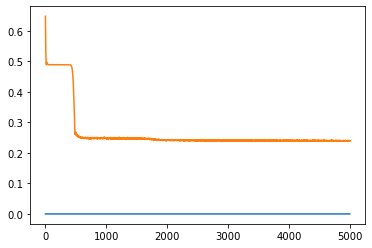

In [6]:
# set number of iterations desired for training
iterations = 20000

losses = []
start = time.time()

# load the current working version of the model
# Allows training to resume from last saved model
if filepath_to_load_model is not None:
    net.load_state_dict(torch.load(filepath_to_load_model,map_location=device))

# for the number of iterations defined
for epoch in range(iterations):
    # clear the optimizer for new input
    optimizer.zero_grad()
    
    # Loss based on boundary condition u(0,x)
    net_bc_out = net(bc_all_zeros, bc_x)
    mse_u = mse_cost_function(net_bc_out, bc_u)
    
    # Loss based on boundary condition u(t,1)
    net_bc_out = net(bc_t, bc_all_ones)
    mse_one = mse_cost_function(net_bc_out, bc_all_zeros)
    
    # Loss based on boundary condition u(t,-1)
    net_bc_out = net(bc_t, bc_all_neg_ones)
    mse_none = mse_cost_function(net_bc_out, bc_all_zeros)
    
    # define random sample of values with variable boundaries for input
    x_pt = np.random.uniform(low=-1.0, high=1.0, size=(pt_size,1))
    t_pt = np.random.uniform(low=0.0, high=1.0, size=(pt_size,1))
    
    #convert values to tensor for model processing
    pt_x_collocation = Variable(torch.from_numpy(x_pt).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_pt).float(), requires_grad=True).to(device)
    
    # calculate loss based on PDE
    f_out = f(pt_t_collocation, pt_x_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)
    
    # Combine all errors to calculate overall loss
    loss = mse_u + mse_f + mse_one + mse_none
    
    # use back propogation to pass the resulting loss backwards through the model
    # optimizer attempts to reduce the loss to zero
    loss.backward() 
    optimizer.step()

    with torch.autograd.no_grad():
        # adds the current loss to a list for future analysis/graphing
        losses.append(float(loss.data))
        
        # prints out status update every n iteration
        if (epoch+1)%1000 == 0:
            print(epoch+1,"Training Loss:",loss.data)
            
            # saves current working copy of model in case of crash
            torch.save(net.state_dict(), filepath_to_save_model)
            
    
    
# save final trained model
torch.save(net.state_dict(), filepath_to_save_model)

# print completion message
print('Completed',epoch+1,'iterations in',round((time.time()-start)/60,0), 'minutes')

# show graph of loss over training iterations
xs = list(range(len(losses)))
ys = np.zeros((len(losses),1))
plt.plot(xs,ys)
plt.plot(xs,losses)
plt.show()

## 8. Analyzing the Results
Overall performance of the model can be evaluated using the known sample data and the models outputs. Loss between the outputted functions can be calculated and used to track accuracy. Model performance can also be visualized by graphing the predicted functions against the exact values. These results can be represented in the 3 dimensional space or compressed into a 2 dimensional heat map.

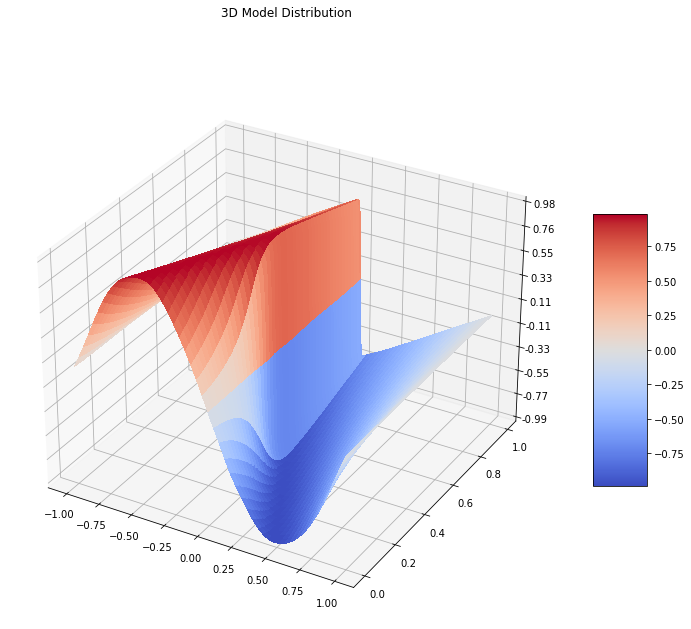

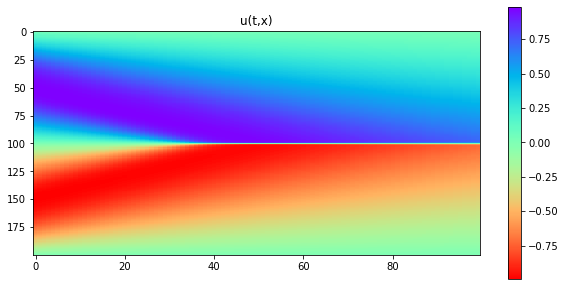

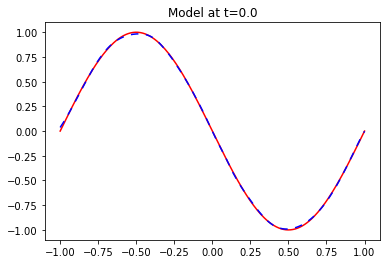

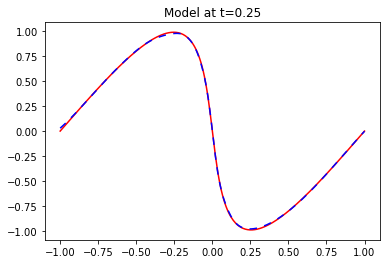

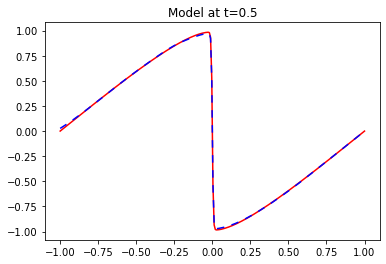

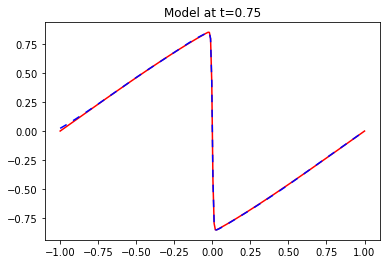

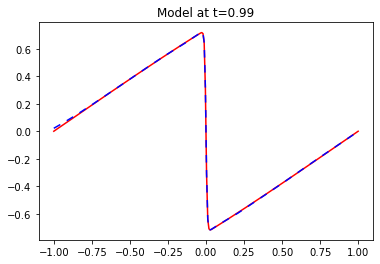

In [7]:
# loads trained model for analysis
net = Net()
net.load_state_dict(torch.load(filepath_to_save_model,map_location=device))

# function to print the 3d distribution of the model output
def plot_3D_map(net):
    # initialize the 3D figure
    fig = plt.figure(figsize = (15,10))
    ax = fig.gca(projection='3d')
    fig.suptitle('3D Model Distribution')

    # get values between variable boundaries at constant increments 
    x=np.arange(-1,1,0.01)
    t=np.arange(0,1,0.01)
    
    # orient values in proper format for processing
    ms_t, ms_x = np.meshgrid(t, x)
    x = np.ravel(ms_x).reshape(-1,1)
    t = np.ravel(ms_t).reshape(-1,1)

    # convert values to tensors for model input
    pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    # get the model output for the given inputs
    pt_u = net(pt_t,pt_x)
    u=np.asarray(pt_u.data)
    ms_u = u.reshape(ms_x.shape)
    
    # plot the 3D data
    surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()
    
# function creates 2D heat map of model output at given inputs
def plot_heat_map(net):
    # get values between variable boundaries at constant increments 
    x=np.arange(-1,1,0.01)
    t=np.arange(0,1,0.01)
    
    # orient values in proper format for processing
    ms_t, ms_x = np.meshgrid(t, x)
    xx = np.ravel(ms_x).reshape(-1,1)
    tt = np.ravel(ms_t).reshape(-1,1)
    
    # convert values to tensors for model processing 
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(tt).float(), requires_grad=True).to(device)
    
    # get model output for given inputs
    pt_u = net(pt_t,pt_x)
    u=np.asarray(pt_u.data)
    u = u.reshape(ms_x.shape)
    
    # plot 2D heat map
    fig = plt.figure(figsize=(10,5))
    plt.imshow(u, cmap='rainbow_r', interpolation='nearest', aspect=.25)
    plt.title("u(t,x)")
    plt.colorbar()
    plt.show()
    
# function compares predicted values at constant time to exact values
def plot_t_value(t_value, net):
    # read in sample data for testing
    data = pd.read_csv(data_filepath)
    
    # get values from data columns
    x = np.asarray(data['Unnamed: 0'].astype(float))
    xx = x.reshape(-1,1)
    y = data[str(t_value)]
    t = np.ones((len(x),1))*t_value
    
    # convert values to tensors for model processing
    pt_x = Variable(torch.from_numpy(xx).float(), requires_grad=True).to(device)
    pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    
    # get model output for given inputs
    pt_u = net(pt_t,pt_x)
    u=np.asarray(pt_u.data)
    
    # plot exact values as red line
    plt.plot(x,y,'r')
    
    # plot predicted values as blue dashed line
    plt.plot(x,u,'blue', linestyle=(0,(5,5)))
    plt.title('Model at t='+str(t_value))
    plt.show()

    
    
plot_3D_map(net)
plot_heat_map(net)
plot_t_value(0.0,net)
plot_t_value(0.25,net)
plot_t_value(0.50,net)
plot_t_value(0.75,net)
plot_t_value(0.99,net)